In [12]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
data_folder = f"../data"

sample_filename = "muestreos_parcelas_utm.parquet"

df_samples = pd.read_parquet(f"{data_folder}/{sample_filename}")
#df_samples.head(20).to_csv("sample_parcelas.txt", sep="\t")

df_samples["fecha"] = pd.to_datetime(df_samples["fecha"])
df_samples.sort_values(by="fecha", inplace=True)

df_samples['año'] = df_samples['fecha'].dt.year

df_samples.info()

<class 'pandas.core.frame.DataFrame'>
Index: 581793 entries, 119217 to 541761
Data columns (total 63 columns):
 #   Column                                              Non-Null Count   Dtype         
---  ------                                              --------------   -----         
 0   generated_muestreos                                 581793 non-null  datetime64[us]
 1   codparcela                                          581793 non-null  category      
 2   provincia                                           581793 non-null  string        
 3   municipio                                           581793 non-null  object        
 4   fecha                                               581793 non-null  datetime64[us]
 5   campaña                                             581793 non-null  uint16        
 6   poligono                                            581731 non-null  UInt16        
 7   parcela                                             581763 non-null  UInt16        

In [14]:
# Adding the number of days till next visit for each row
df_samples["next_date"] = df_samples.groupby("codparcela", observed=True)["fecha"].shift(-1)
df_samples["days_until_next_visit"] = (df_samples["next_date"] - df_samples["fecha"]).dt.days


# # Removing the parcels with only one entry and the last entry for every parcel (we would need to also add the y value of the next entry)

df_samples = df_samples.dropna(subset=["days_until_next_visit"])  # 5150 entries removed
df_samples["days_until_next_visit"] = df_samples["days_until_next_visit"].astype("int32")


In [15]:
parcelas_30_days = df_samples[df_samples["days_until_next_visit"] > 30]["codparcela"].unique()
parcelas_10_days = df_samples[df_samples["days_until_next_visit"] > 10]["codparcela"].unique()

df_sample_reduced_30days = df_samples[~df_samples["codparcela"].isin(parcelas_30_days)]  # 18.7k entries removed
df_sample_reduced_10days = df_samples[~df_samples["codparcela"].isin(parcelas_10_days)]  # 69.3k entries removed

df_sample_reduced_30days.to_parquet("../data/muestreos_parcelas_utm_30days.parquet")
df_sample_reduced_10days.to_parquet("../data/muestreos_parcelas_utm_10days.parquet")

(1.0, 30.0)

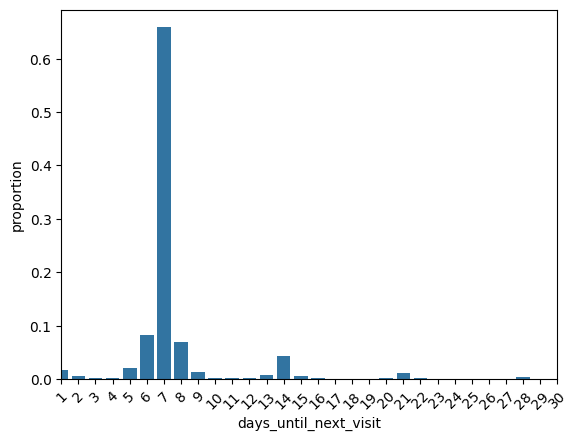

In [16]:
sns.countplot(x="days_until_next_visit", stat="proportion", data=df_samples)
plt.xticks(rotation=45)
plt.xlim(1, 30)

In [6]:
#group_dates = df_samples.groupby(["codparcela"])["fecha"].agg([('min_fecha', 'min'), ('max_fecha', 'max')]).reset_index()

group_dates = df_samples.groupby(["codparcela", "año", "fecha"])["fecha"].agg([('min_fecha', 'min'), ('max_fecha', 'max')]).reset_index()
#group_max_diff_days = df_samples.groupby(["codparcela", "año", "days_until_next_visit"])["days_until_next_visit"].agg([('max_days_until_next_visit', 'max')]).reset_index()

#group_coords = df_samples.groupby("codparcela")[["municipio", "102_coordenada_x_(utm)", "103_coordenada_y_(utm)", "huso_etrs89_regcan95"]].apply("first").reset_index()


/tmp/ipykernel_33929/269333800.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_dates = df_samples.groupby(["codparcela", "año", "fecha"])["fecha"].agg([('min_fecha', 'min'), ('max_fecha', 'max')]).reset_index()


: 

In [17]:
group_dates_30_days = df_sample_reduced_30days.groupby(["codparcela"])["fecha"].agg([('min_fecha', 'min'), ('max_fecha', 'max')]).reset_index()
group_coords_30_days = df_sample_reduced_30days.groupby("codparcela")[["municipio", "102_coordenada_x_(utm)", "103_coordenada_y_(utm)", "huso_etrs89_regcan95"]].apply("first").reset_index()

result_30_days = pd.merge(group_dates_30_days, group_coords_30_days, on='codparcela', how='inner')

result_30_days["days"] = (result_30_days["max_fecha"] - result_30_days["min_fecha"]).dt.days

result_30_days.dropna(inplace=True)

result_30_days.to_csv(f"{data_folder}/parcelas_30_days.txt", "\t")

/tmp/ipykernel_39621/3442132965.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_dates_30_days = df_sample_reduced_30days.groupby(["codparcela"])["fecha"].agg([('min_fecha', 'min'), ('max_fecha', 'max')]).reset_index()
/tmp/ipykernel_39621/3442132965.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_coords_30_days = df_sample_reduced_30days.groupby("codparcela")[["municipio", "102_coordenada_x_(utm)", "103_coordenada_y_(utm)", "huso_etrs89_regcan95"]].apply("first").reset_index()


In [18]:
group_dates_10_days = df_sample_reduced_10days.groupby(["codparcela"])["fecha"].agg([('min_fecha', 'min'), ('max_fecha', 'max')]).reset_index()
group_coords_10_days = df_sample_reduced_10days.groupby("codparcela")[["municipio", "102_coordenada_x_(utm)", "103_coordenada_y_(utm)", "huso_etrs89_regcan95"]].apply("first").reset_index()

result_10_days = pd.merge(group_dates_10_days, group_coords_10_days, on='codparcela', how='inner')

result_10_days["days"] = (result_10_days["max_fecha"] - result_10_days["min_fecha"]).dt.days

result_10_days.dropna(inplace=True)



/tmp/ipykernel_39621/4277458561.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_dates_10_days = df_sample_reduced_10days.groupby(["codparcela"])["fecha"].agg([('min_fecha', 'min'), ('max_fecha', 'max')]).reset_index()
/tmp/ipykernel_39621/4277458561.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_coords_10_days = df_sample_reduced_10days.groupby("codparcela")[["municipio", "102_coordenada_x_(utm)", "103_coordenada_y_(utm)", "huso_etrs89_regcan95"]].apply("first").reset_index()


In [22]:
result = pd.read_csv(f"{data_folder}/parcelas.txt", sep="\t", parse_dates=["min_fecha", "max_fecha"])
result.dropna(inplace=True)

result.drop(columns=["Unnamed: 0.3", "Unnamed: 0.2", "Unnamed: 0.1", "Unnamed: 0"], inplace=True)


result.head()

,codparcela,min_fecha,max_fecha,102_coordenada_x_(utm),103_coordenada_y_(utm),days,lat,lon
0,000-00000-00,2015-08-25,2015-09-30,276171.00,4082574.00,36,36.862604,-5.510871
1,000-00000-00-0,2015-08-24,2015-09-29,232382.86,4072834.94,36,36.763544,-5.998092
2,000-00900-00-U0,2006-04-24,2009-11-16,449521.00,4124050.00,1302,37.261645,-3.569286
3,000-00999-00-00,2006-05-02,2009-11-18,449772.00,4123208.00,1296,37.254069,-3.566399
4,000-00999-00-FC,2006-05-02,2006-10-31,449772.00,4123208.00,182,37.254069,-3.566399


In [23]:
import utm


def utm_to_latlon(row):
    try:
        lat, lon = utm.to_latlon(row["102_coordenada_x_(utm)"], row["103_coordenada_y_(utm)"], 30, 'S')
    except:
        lat, lon = -9999999, -9999999

    return pd.Series([lat, lon], index=['lat', 'lon'])


result_10_days[['lat', 'lon']] = result_10_days.apply(utm_to_latlon, axis=1)
result_30_days[['lat', 'lon']] = result_30_days.apply(utm_to_latlon, axis=1)
result[['lat', 'lon']] = result.apply(utm_to_latlon, axis=1)

result_10_days[(result_10_days["lat"] < 40) &
               (result_10_days["lat"] > 35) &
               (result_10_days["lat"] > -10) &
               (result_10_days["lat"] > -10)]

result_30_days[(result_30_days["lat"] < 40) &
               (result_30_days["lat"] > 35) &
               (result_30_days["lat"] > -10) &
               (result_30_days["lat"] > -10)]

result[(result_30_days["lat"] < 40) &
               (result["lat"] > 35) &
               (result["lat"] > -10) &
               (result["lat"] > -10)]


result.to_csv(f"{data_folder}/parcelas.txt", "\t", index=None)
result_10_days.to_csv(f"{data_folder}/parcelas_10_days.txt", "\t")
result_30_days.to_csv(f"{data_folder}/parcelas_30_days.txt", "\t")


result_30_days.head()

/tmp/ipykernel_39621/97896288.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result[(result_30_days["lat"] < 40) &


,codparcela,min_fecha,max_fecha,municipio,102_coordenada_x_(utm),103_coordenada_y_(utm),huso_etrs89_regcan95,days,lat,lon
4,000-00999-00-FC,2006-05-02,2006-10-25,nivar,449772.00,4123208.00,30.0,176.0,37.254069,-3.566399
5,001-00001-00-06,2012-03-27,2012-04-23,montejicar,455827.26,4161193.04,30.0,27.0,37.596752,-3.500392
18,001-00004-00-10,2006-04-28,2006-11-08,guadalcazar,326630.00,4183572.00,30.0,194.0,37.783070,-4.968778
22,001-00006,2020-04-07,2020-10-13,ubeda,464989.00,4221345.00,30.0,189.0,38.139289,-3.399527
23,001-00006-00-00,2006-03-22,2006-11-14,monturque,361200.00,4152500.00,30.0,237.0,37.509016,-4.570450


In [26]:
result = result[(result["max_fecha"].dt.year>=2016) &
                (result["days"]>=60)].sort_values(by="days", ascending=False)

result.head()

,codparcela,min_fecha,max_fecha,102_coordenada_x_(utm),103_coordenada_y_(utm),days,lat,lon
3160,020-00214-00-00,2006-03-10,2021-09-23,377518.000,4197104.00,5676,37.913239,-4.393380
1674,009-00015-00-00,2006-03-22,2021-09-23,311584.000,4174787.00,5664,37.700966,-5.137257
537,003-00073-00-00,2006-05-08,2021-09-23,491145.000,4194796.00,5617,37.900643,-3.100722
4380,043-00145-00-00,2006-03-01,2021-03-16,416689.344,4134089.73,5494,37.349772,-3.940642
2529,015-00002-00-00,2006-03-08,2021-03-16,297633.000,4167623.00,5487,37.633472,-5.293408


In [27]:
result.to_csv("parcelas_download.txt", sep="\t", index=None)

In [31]:
from datetime import datetime, date
import requests
import matplotlib.pyplot as plt
import numpy as np

def getTimeseriesForPoint(covId,
                          tsvBaseURL,
                          start,
                          end,
                          lat,
                          lon,
                          printURL=False):

    tsURL = tsvBaseURL + covId + '/point'
    payload = {
            'lon': str(lon),
            'lat': str(lat),
            'startDate': start.strftime('%Y-%m-%d'),
            'endDate': end.strftime('%Y-%m-%d')
    }
    if printURL:
        print(tsURL,payload)
    response=requests.get(tsURL,params=payload)
    if response.status_code == 200:
        timeseries = response.json()['results']
        return(timeseries)
    else:
        return([])

In [60]:
for i, row in result.iterrows():

    id_parcela = row["codparcela"]
    start_time = datetime.strptime(row["min_fecha"].strftime("%d-%m-%Y"), "%d-%m-%Y")
    end_time =datetime.strptime(row["max_fecha"].strftime("%d-%m-%Y"), "%d-%m-%Y")

    start_time_document = start_time.strftime("%Y_%m_%d")
    end_time_document = end_time.strftime("%Y_%m_%d")

    lat_pd = row["lat"]
    lon_pd = row["lon"]
    


    TSlayers = ["BIOPAR_FAPAR_V2_GLOBAL",
        "BIOPAR_NDVI_V2_GLOBAL"]

    for l in TSlayers:
        ts = getTimeseriesForPoint(covId=l,
                            tsvBaseURL='https://services.terrascope.be/timeseries/v1.0/ts/',
                                start=start_time,
                                end=end_time,
                                lat=lat_pd,
                                lon=lon_pd,
                                printURL=False)

        df = pd.DataFrame()
        n_points = len(ts)
        dates = [ts[i]["date"] for i in range(n_points)]
        values = [ts[i]["result"]["average"] for i in range(n_points)]

        df["date"] = dates
        df["value"] = values

        df.to_csv(f"{data_folder}/datos_parcela/{id_parcela}_{l}_{start_time_document}_{end_time_document}.txt", sep="\t")


,date,value
0,2006-03-11,0.384
1,2006-03-21,0.448
2,2006-04-01,0.396
3,2006-04-11,0.384
4,2006-04-21,0.292
...,...,...
529,2020-11-21,0.38
530,2020-12-01,0.416
531,2020-12-11,0.356
532,2020-12-21,0.432


In [37]:
tss[0][1]["date"]

'2006-03-20'

In [103]:
import requests
import matplotlib.pyplot as plt
import numpy as np
tsvBaseURL='https://services.terrascope.be/timeseries/v1.0/ts/'

response = requests.get(tsvBaseURL) #this returns the layers that are available

if response.status_code == 200:
    layerlist = response.json()['layers']
else:
    raise IOError(response.text)

,codparcela,min_fecha,max_fecha,municipio,102_coordenada_x_(utm),103_coordenada_y_(utm),huso_etrs89_regcan95,days,lat,lon
4,000-00999-00-FC,2006-05-02,2006-10-25,nivar,449772.00,4123208.00,30.0,176.0,37.254069,-3.566399
5,001-00001-00-06,2012-03-27,2012-04-23,montejicar,455827.26,4161193.04,30.0,27.0,37.596752,-3.500392
18,001-00004-00-10,2006-04-28,2006-11-08,guadalcazar,326630.00,4183572.00,30.0,194.0,37.783070,-4.968778
22,001-00006,2020-04-07,2020-10-13,ubeda,464989.00,4221345.00,30.0,189.0,38.139289,-3.399527
23,001-00006-00-00,2006-03-22,2006-11-14,monturque,361200.00,4152500.00,30.0,237.0,37.509016,-4.570450
